#Web Traffic Time Series Forecasting : Ad Ease website Analytics


Forecasting the future values of multiple time series. More specifically the problem of forecasting future web traffic for approximately 145,000 articles on britanica.

The training dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different article, starting from July, 1st, 2015 up until December 31st, 2016.
For each time series, you are provided the name of the article as well as the type of traffic that this time series represent (all, mobile, desktop, spider). You may use this metadata and any other publicly available data to make predictions. Unfortunately, the data source for this dataset does not distinguish between traffic values of zero and missing values. A missing value may mean the traffic was zero or that the data is not available for that day.

***Data Dictionary:***

there are two csv files given


**train_1.csv : **

In the csv file, each row corresponds to a particular article and each column correspond to a particular date. The values are the number of visits in that date.


**Exog_Campaign_eng : **

this file contains data for the dates which had a campaign or significant event that could affect the views for that day.
the data is just for pages in english.

there is a 1 for dates with campaign and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in english


1. Data Loading

2. EDA

3. Data preparation (checking stationarity, transformations)

4. Model prediction

5. Evaluation

# Data Loading

**Importing the libraries**

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plt
from collections import Counter
import re
import os
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
sns.set(rc={'figure.figsize':(11.7,8.27)})


In [ ]:
import gdown
#url='https://drive.google.com/file/d/1gHYYLqLt6rMyeAyvHf1wvlQ4BLKwjv9W/view?usp=sharing'
#url='https://drive.google.com/file/d/1SL_7DoE16m71QpjJXoQUC3cI5aHCIZLv/view?usp=share_link'
#url='https://drive.google.com/file/d/11GQSe2Xm4vFD4Xfw3JhOoPlXnBE_LiMe/view?usp=sharing'
url='https://drive.google.com/file/d/1CJOMYyg64x3gN52p6OqypN6UUgDnUhkm/view?usp=sharing'

ider=url.split('/')[-2]
!gdown --id $ider

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1CJOMYyg64x3gN52p6OqypN6UUgDnUhkm
From (redirected): https://drive.google.com/uc?id=1CJOMYyg64x3gN52p6OqypN6UUgDnUhkm&confirm=t&uuid=b4321d49-7e6c-4aab-bc98-0837f4c33b53
To: /content/new_train.csv
100% 425M/425M [00:07<00:00, 55.0MB/s]


In [ ]:
train = pd.read_csv('new_train.csv')

In [ ]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.britanica.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.britanica.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.britanica.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.britanica.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.britanica.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## Null values

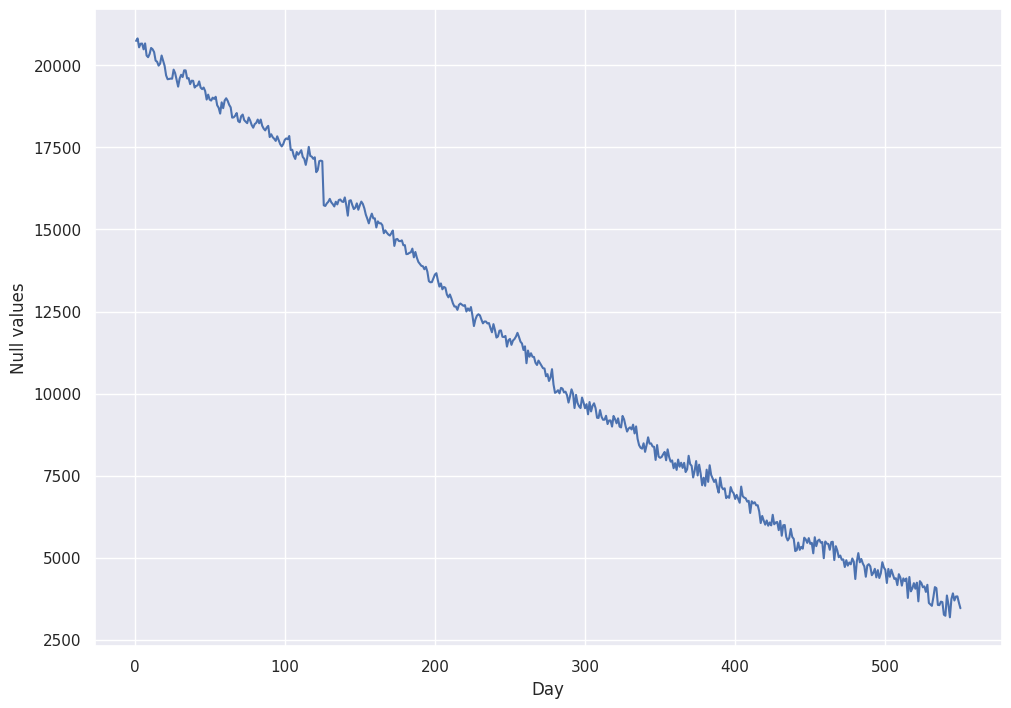

In [ ]:
plt.xlabel('Day')
plt.ylabel('Null values')
plt.plot([r for r in range(1, len(train.columns))],train.isnull().sum()[1:])
plt.show()

We see that the number of nan values decrease with time.

Some website have all nan values in the beginning, that can be due to the fact that those were created after that time so there is no traffic reading for that time.

In [ ]:
print(train.shape)
train=train.dropna(how='all')
#‘all’ : If all values are NA, drop that row or column.
print(train.shape)

train=train.dropna(thresh=300)
print(train.shape)

(145063, 551)
(145063, 551)
(133617, 551)



1. We try droping the rows that have all values as nan, none in our case.

2. We then also drop rows that have nan more than 300 days, because the time series for that would not make much sense

3. We fill all the remaining values with zero assuming there was no traffic on the date that the values are nan for.

In [ ]:
train=train.fillna(0)
train.tail()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
145012,Legión_(Marvel_Comics)_es.britanica.org_all-ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,3.0,2.0,4.0,2.0,4.0,4.0,1.0,2.0,2.0
145013,Referéndum_sobre_la_permanencia_del_Reino_Unid...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,16.0,8.0,3.0,6.0,3.0,3.0,10.0,11.0,3.0
145014,Salida_del_Reino_Unido_de_la_Unión_Europea_es....,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,36.0,23.0,182.0,43.0,8.0,22.0,13.0,18.0,14.0
145015,"Amar,_después_de_amar_es.britanica.org_all-acc...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,30.0,27.0,14.0,8.0,7.0,5.0,43.0,12.0,25.0
145016,Anexo:89.º_Premios_Óscar_es.britanica.org_all-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


# EDA


In [ ]:
train['Page'].iloc[0]

'2NE1_zh.britanica.org_all-access_spider'

 The page values are in this format


 **SPECIFIC NAME _ LANGUAGE.britanica.org _ ACCESS TYPE _ ACCESS ORIGIN**

having information about page name, the main domain, device type used to access the page, and also the request origin(spider or browser agent)


In [ ]:
re.split('_|\.','2NE1_zh.britanica.org_all-access_spider')

['2NE1', 'zh', 'britanica', 'org', 'all-access', 'spider']

Since all are britanica articles, we just need info about  'Specific name','language','access type','access origin'

In [ ]:
def split_page(page):
  w= re.split('_|\.','2NE1_zh.britanica.org_all-access_spider')
  print (' '.join(w[:-5]), w[-5], w[-2], w[-1])
  print(w[0],w[1],w[2],w[3],w[4],w[5])
  return w[0],w[1],w[4],w[5]

split_page('2NE1_zh.britanica.org_all-access_spider')

2NE1 zh all-access spider
2NE1 zh britanica org all-access spider


('2NE1', 'zh', 'all-access', 'spider')

In [ ]:
train.tail()['Page'].iloc[-1]

'Anexo:89.º_Premios_Óscar_es.britanica.org_all-access_spider'

In [ ]:
re.split('_|\.',train.tail()['Page'].iloc[-1])

['Anexo:89',
 'º',
 'Premios',
 'Óscar',
 'es',
 'britanica',
 'org',
 'all-access',
 'spider']

In [ ]:
x=re.split('_|\.',train.tail()['Page'].iloc[-1])
print(" ".join(x[:-5]),x[-5],x[-2],x[-1])

Anexo:89 º Premios Óscar es all-access spider


In [ ]:
def split_page(page):
  w= re.split('_|\.',page)
  return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

li=list(train.Page.apply(lambda x: split_page(str(x))))
df=pd.DataFrame(li,columns=['Title','Language','Access_type','Access_origin'])
df.head()

,Title,Language,Access_type,Access_origin
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,5566,zh,all-access,spider


In [ ]:
df.tail()

,Title,Language,Access_type,Access_origin
133612,Legión (Marvel Comics),es,all-access,spider
133613,Referéndum sobre la permanencia del Reino Unid...,es,all-access,spider
133614,Salida del Reino Unido de la Unión Europea,es,all-access,spider
133615,"Amar, después de amar",es,all-access,spider
133616,Anexo:89 º Premios Óscar,es,all-access,spider


In [ ]:
train.shape,df.shape

((133617, 551), (133617, 4))

In [ ]:
df = pd.concat([train, df], axis = 1)
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Language,Access_type,Access_origin
0,2NE1_zh.britanica.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.britanica.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.britanica.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.britanica.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
5,5566_zh.britanica.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,32.0,19.0,23.0,17.0,17.0,50.0,A'N'D,zh,all-access,spider


**Count of articles by language, access type, access origin**

{'ja':'Japanese', 'de':'German',  'en' : 'English',  'no_lang':'Media_File',  'fr':'French',  'zh':'Chinese',  'ru':'Russian',  'es':'Spanish'}

<Axes: xlabel='Access_type', ylabel='count'>

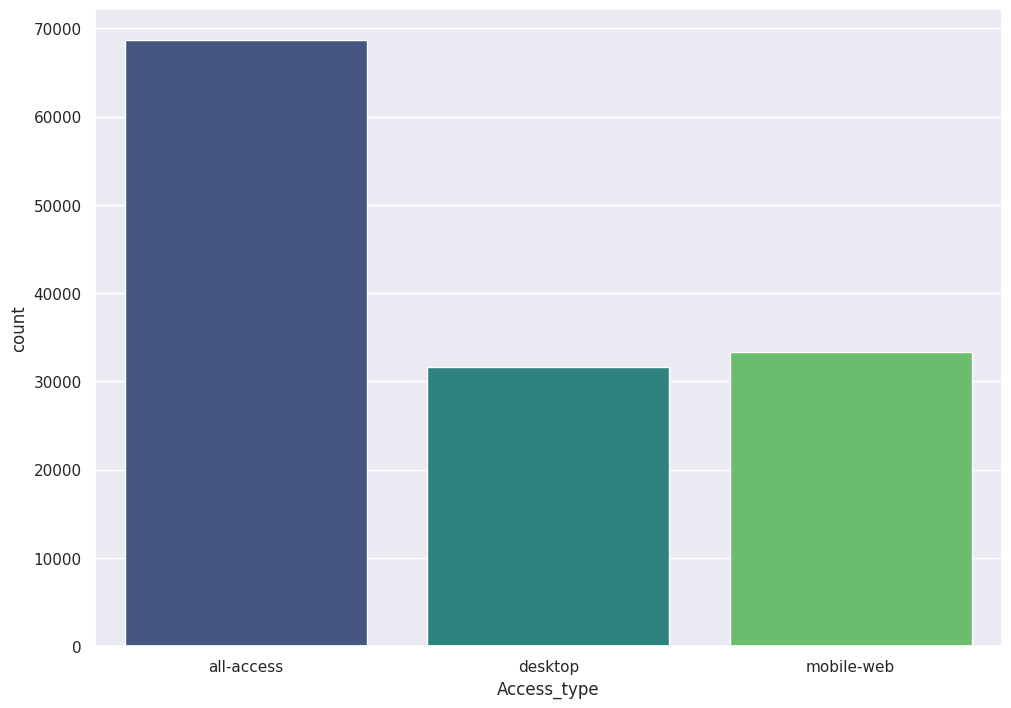

In [ ]:
sns.countplot(df,x='Access_type',palette='viridis')

<Axes: xlabel='Access_origin', ylabel='count'>

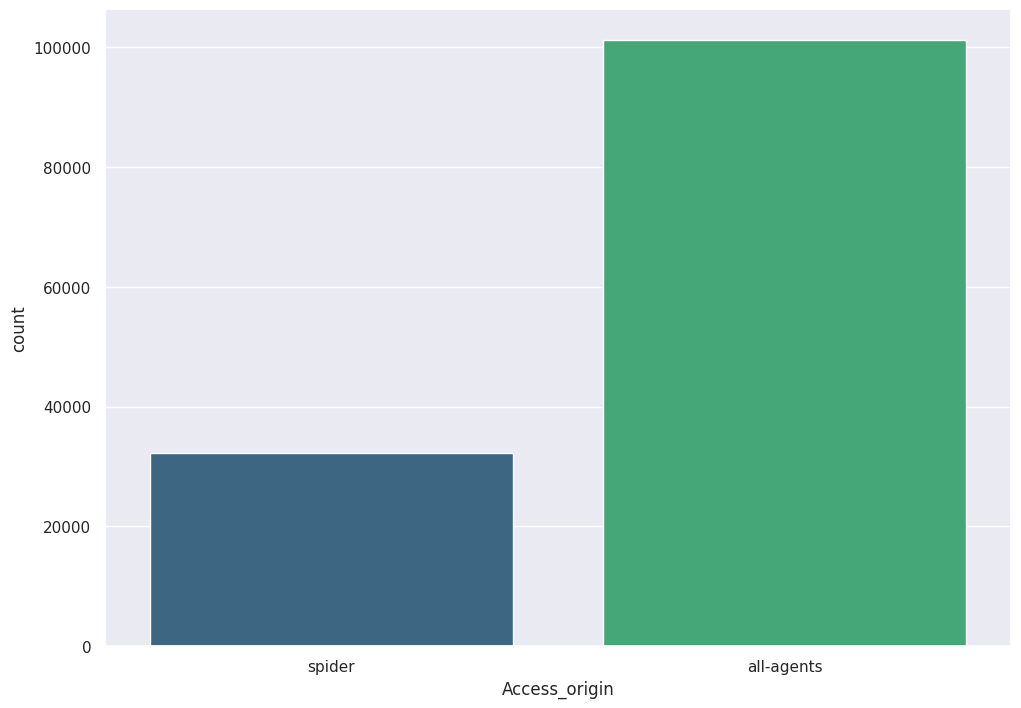

In [ ]:
sns.countplot(df,x='Access_origin',palette='viridis')

<Axes: xlabel='Language', ylabel='count'>

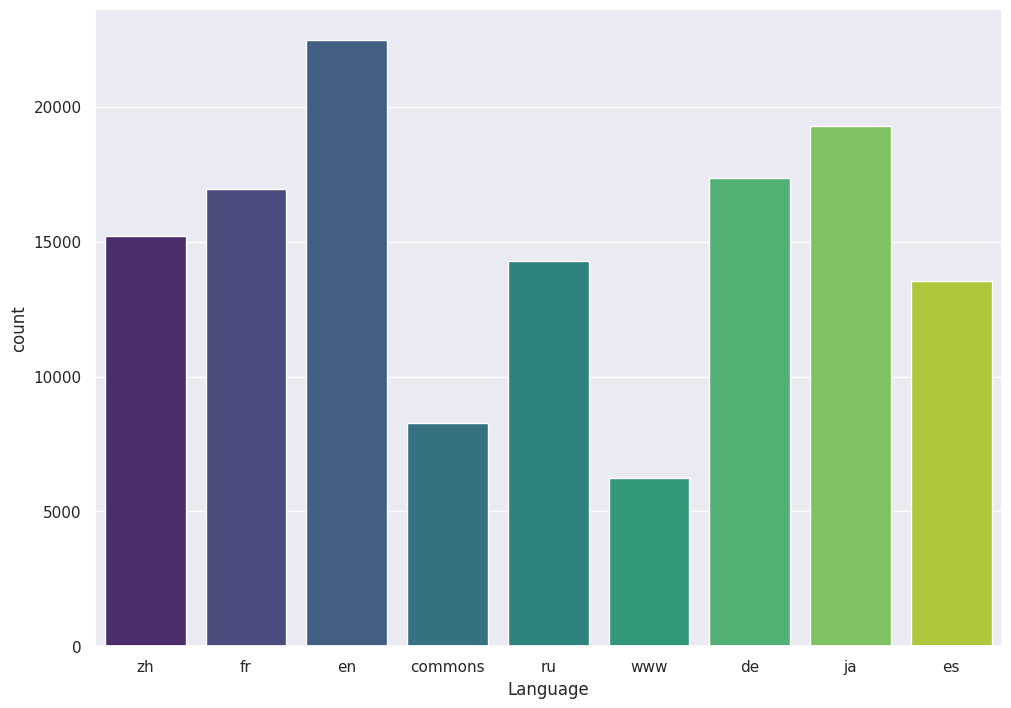

In [ ]:
sns.countplot(df,x='Language',palette='viridis')

## Making time series by languages

Here languages also include *commons* and *www* which need furthur investigation

In [ ]:
df.groupby('Language').count()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Access_type,Access_origin
Language,,,,,,,,,,,,,,,,,,,,,
commons,7672,7672,7672,7672,7672,7672,7672,7672,7672,7672,...,7672,7672,7672,7672,7672,7672,7672,8266,8266,8266
de,15946,15946,15946,15946,15946,15946,15946,15946,15946,15946,...,15946,15946,15946,15946,15946,15946,15946,17362,17362,17362
en,20758,20758,20758,20758,20758,20758,20758,20758,20758,20758,...,20758,20758,20758,20758,20758,20758,20758,22486,22486,22486
es,12268,12268,12268,12268,12268,12268,12268,12268,12268,12268,...,12268,12268,12268,12268,12268,12268,12268,13551,13551,13551
fr,15418,15418,15418,15418,15418,15418,15418,15418,15418,15418,...,15418,15418,15418,15418,15418,15418,15418,16948,16948,16948
ja,17132,17132,17132,17132,17132,17132,17132,17132,17132,17132,...,17132,17132,17132,17132,17132,17132,17132,19295,19295,19295
ru,12955,12955,12955,12955,12955,12955,12955,12955,12955,12955,...,12955,12955,12955,12955,12955,12955,12955,14270,14270,14270
www,5743,5743,5743,5743,5743,5743,5743,5743,5743,5743,...,5743,5743,5743,5743,5743,5743,5743,6228,6228,6228
zh,14845,14845,14845,14845,14845,14845,14845,14845,14845,14845,...,14845,14845,14845,14845,14845,14845,14845,15211,15211,15211


In [ ]:
df[df['Language']=='commons']

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Language,Access_type,Access_origin
12271,Burning_Man_en.britanica.org_desktop_all-agents,1693.0,1490.0,1186.0,1099.0,1051.0,1968.0,1874.0,1637.0,1842.0,...,940.0,2976.0,2447.0,1648.0,1282.0,956.0,Accueil,commons,all-access,spider
12272,Cali_Cartel_en.britanica.org_desktop_all-agents,348.0,363.0,214.0,252.0,257.0,320.0,340.0,345.0,432.0,...,1197.0,1449.0,1376.0,1350.0,1287.0,992.0,Atlas of Asia,commons,all-access,spider
12273,Call_of_Duty:_Modern_Warfare_2_en.britanica.or...,806.0,768.0,700.0,725.0,723.0,823.0,849.0,731.0,833.0,...,818.0,929.0,892.0,878.0,893.0,712.0,Atlas of Europe,commons,all-access,spider
12274,Calvin_Harris_en.britanica.org_desktop_all-agents,7114.0,5599.0,7685.0,15844.0,9390.0,7173.0,5499.0,6367.0,5630.0,...,1242.0,1409.0,1714.0,1604.0,1602.0,1300.0,Atlas of World War II,commons,all-access,spider
12275,Carl_Sagan_en.britanica.org_desktop_all-agents,1808.0,1759.0,1838.0,1631.0,1701.0,2230.0,2052.0,2065.0,2002.0,...,1425.0,1730.0,1858.0,1781.0,1718.0,1345.0,Atlas of colonialism,commons,all-access,spider
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,File:Zyworodka - Kalanchoe daigremontiana JPG,commons,desktop,all-agents
75150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Commons:Open proxy detection,commons,desktop,all-agents
75178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,File:Crabs (Pachygrapsus marmoratus) webm,commons,desktop,all-agents
75237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Басты бет,commons,desktop,all-agents


In [ ]:
df.loc[12275].Page

'Carl_Sagan_en.britanica.org_desktop_all-agents'

In [ ]:
val=re.search('[a-z][a-z].britanica.org',df.loc[12275].Page)
val,val[0],val[0][0:2]

(<re.Match object; span=(11, 27), match='en.britanica.org'>,
 'en.britanica.org',
 'en')

In [ ]:
# Checking another way of fetching the language out of the string
def lang(Page):
    val = re.search('[a-z][a-z].britanica.org',Page)
    if val:
        #print(val)
        #print(val[0][0:2] )

        return val[0][0:2]

    return 'no_lang'

df['Language']=df['Page'].apply(lambda x: lang(str(x)))

In [ ]:
df.groupby('Language').count()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Access_type,Access_origin
Language,,,,,,,,,,,,,,,,,,,,,
de,17362,17362,17362,17362,17362,17362,17362,17362,17362,17362,...,17362,17362,17362,17362,17362,17362,17362,13046,13046,13046
en,22486,22486,22486,22486,22486,22486,22486,22486,22486,22486,...,22486,22486,22486,22486,22486,22486,22486,22486,22486,22486
es,13551,13551,13551,13551,13551,13551,13551,13551,13551,13551,...,13551,13551,13551,13551,13551,13551,13551,10142,10142,10142
fr,16948,16948,16948,16948,16948,16948,16948,16948,16948,16948,...,16948,16948,16948,16948,16948,16948,16948,16948,16948,16948
ja,19295,19295,19295,19295,19295,19295,19295,19295,19295,19295,...,19295,19295,19295,19295,19295,19295,19295,16140,16140,16140
no_lang,14494,14494,14494,14494,14494,14494,14494,14494,14494,14494,...,14494,14494,14494,14494,14494,14494,14494,25374,25374,25374
ru,14270,14270,14270,14270,14270,14270,14270,14270,14270,14270,...,14270,14270,14270,14270,14270,14270,14270,14270,14270,14270
zh,15211,15211,15211,15211,15211,15211,15211,15211,15211,15211,...,15211,15211,15211,15211,15211,15211,15211,15211,15211,15211


In [ ]:
# Convert relevant columns to numeric before calculating the mean
numeric_columns = df.select_dtypes(include=np.number).columns  # Select numeric columns
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')  # Convert to numeric

# Now, calculate the mean after grouping by 'Language'
df_language = df.groupby('Language')[numeric_columns].mean().transpose()
df_language

Language,de,en,es,fr,ja,no_lang,ru,zh
2015-07-01,763.765926,3767.328604,1127.485204,499.092872,614.637160,102.733545,663.199229,272.498521
2015-07-02,753.362861,3755.158765,1077.485425,502.297852,705.813216,107.663447,674.677015,272.906778
2015-07-03,723.074415,3565.225696,990.895949,483.007553,637.451671,101.769629,625.329783,271.097167
2015-07-04,663.537323,3711.782932,930.303151,516.275785,800.897435,86.853871,588.171829,273.712379
2015-07-05,771.358657,3833.433025,1011.759575,506.871666,768.352319,96.254105,626.385354,291.977713
...,...,...,...,...,...,...,...,...
2016-12-27,1119.596936,6314.335275,1070.923400,840.590217,808.541436,155.270181,998.374071,363.066991
2016-12-28,1062.284069,6108.874144,1108.996753,783.585379,807.430163,178.561267,945.054730,369.049701
2016-12-29,1033.939062,6518.058525,1058.660320,763.209169,883.752786,150.873534,909.352207,340.526330
2016-12-30,981.786430,5401.792360,807.551177,710.502773,979.278777,156.049193,815.475123,342.745316


In [ ]:
df_language.reset_index(inplace=True)
df_language

Language,index,de,en,es,fr,ja,no_lang,ru,zh
0,2015-07-01,763.765926,3767.328604,1127.485204,499.092872,614.637160,102.733545,663.199229,272.498521
1,2015-07-02,753.362861,3755.158765,1077.485425,502.297852,705.813216,107.663447,674.677015,272.906778
2,2015-07-03,723.074415,3565.225696,990.895949,483.007553,637.451671,101.769629,625.329783,271.097167
3,2015-07-04,663.537323,3711.782932,930.303151,516.275785,800.897435,86.853871,588.171829,273.712379
4,2015-07-05,771.358657,3833.433025,1011.759575,506.871666,768.352319,96.254105,626.385354,291.977713
...,...,...,...,...,...,...,...,...,...
545,2016-12-27,1119.596936,6314.335275,1070.923400,840.590217,808.541436,155.270181,998.374071,363.066991
546,2016-12-28,1062.284069,6108.874144,1108.996753,783.585379,807.430163,178.561267,945.054730,369.049701
547,2016-12-29,1033.939062,6518.058525,1058.660320,763.209169,883.752786,150.873534,909.352207,340.526330
548,2016-12-30,981.786430,5401.792360,807.551177,710.502773,979.278777,156.049193,815.475123,342.745316


In [ ]:
df_language.set_index('index', inplace=True)

In [ ]:
df_language

Language,de,en,es,fr,ja,no_lang,ru,zh
index,,,,,,,,
2015-07-01,763.765926,3767.328604,1127.485204,499.092872,614.637160,102.733545,663.199229,272.498521
2015-07-02,753.362861,3755.158765,1077.485425,502.297852,705.813216,107.663447,674.677015,272.906778
2015-07-03,723.074415,3565.225696,990.895949,483.007553,637.451671,101.769629,625.329783,271.097167
2015-07-04,663.537323,3711.782932,930.303151,516.275785,800.897435,86.853871,588.171829,273.712379
2015-07-05,771.358657,3833.433025,1011.759575,506.871666,768.352319,96.254105,626.385354,291.977713
...,...,...,...,...,...,...,...,...
2016-12-27,1119.596936,6314.335275,1070.923400,840.590217,808.541436,155.270181,998.374071,363.066991
2016-12-28,1062.284069,6108.874144,1108.996753,783.585379,807.430163,178.561267,945.054730,369.049701
2016-12-29,1033.939062,6518.058525,1058.660320,763.209169,883.752786,150.873534,909.352207,340.526330


Text(0, 0.5, 'Views per Page')

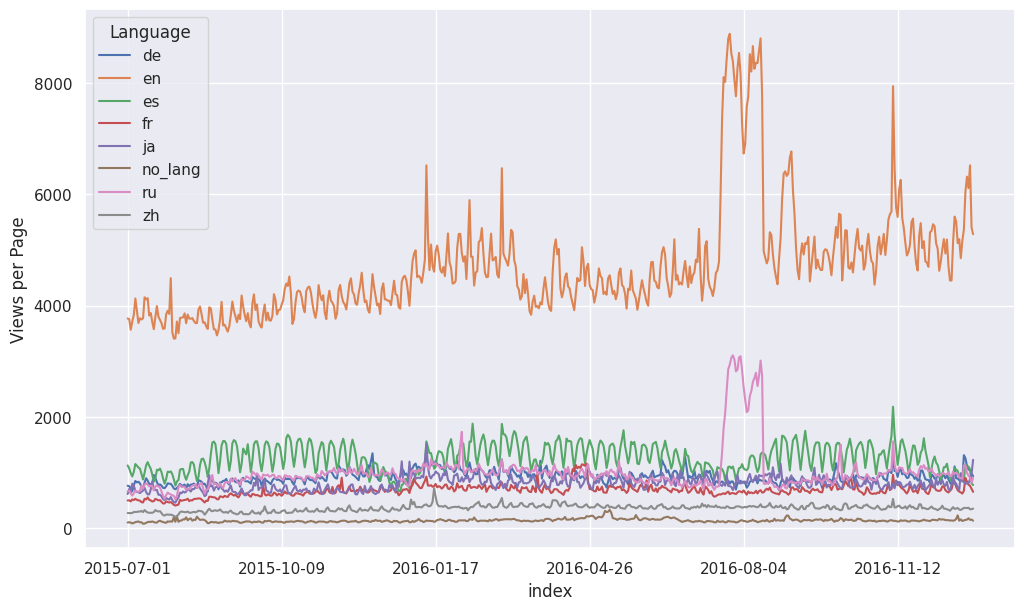

In [ ]:
df_language.plot(figsize=(12,7))
plt.ylabel('Views per Page')

Most articles are in english so that is the dominant time series.

Text(0, 0.5, 'Views per Page')

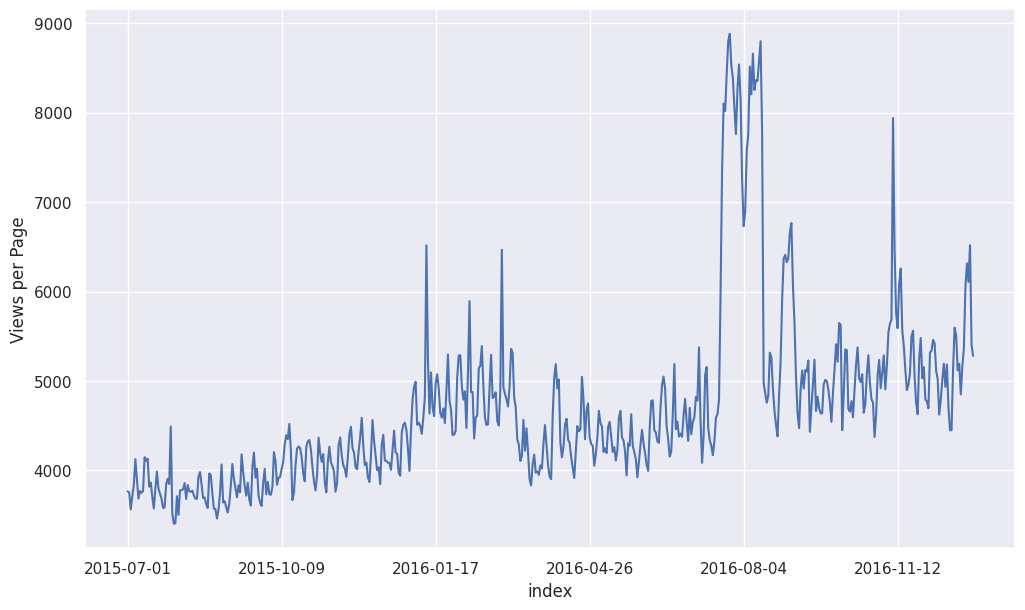

In [ ]:
df_language['en'].plot(figsize=(12,7))
plt.ylabel('Views per Page')

In [ ]:
total_view=df_language.copy()

# Stationarity check - Dickey Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller
def df_test(x):
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])

df_test(total_view['en'])

ADF Stastistic: -2.373563
p-value: 0.149337


p > 0.05 so we accept null hypothesis

TS in non stationary

# Making TS stationary

In [ ]:
ts=total_view['en']

## 1. Remove trend and seasonality with decomposition

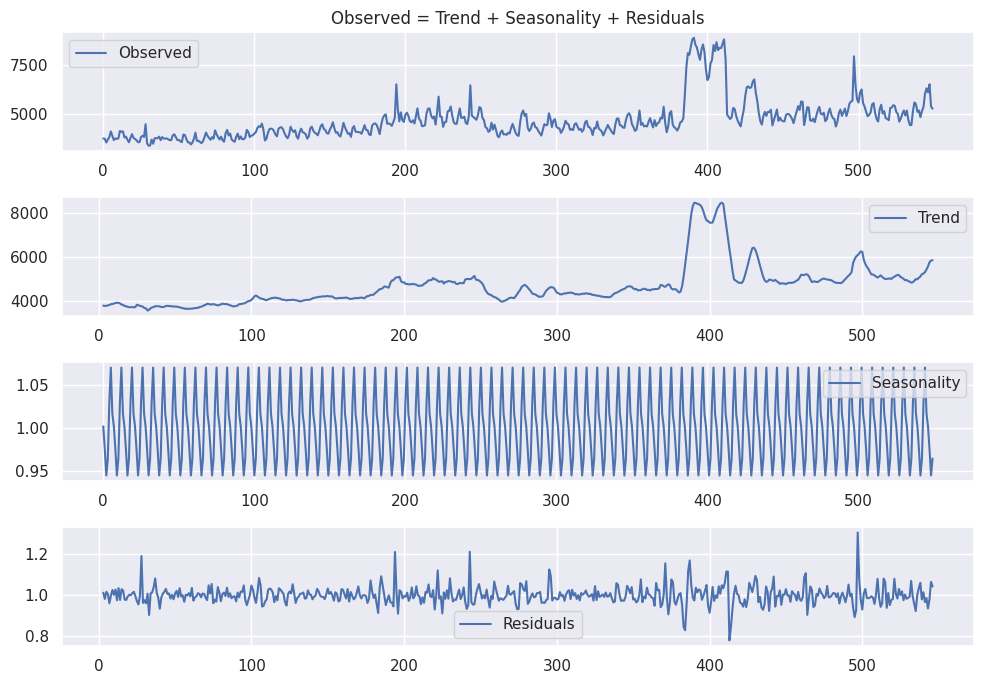

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts.values, model='multiplicative',period = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,7))
plt.subplot(411)
plt.title('Observed = Trend + Seasonality + Residuals')
plt.plot(ts.values,label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
ts_decompose=pd.DataFrame(residual).fillna(0)[0].values
df_test(ts_decompose)

ADF Stastistic: -3.796320
p-value: 0.002945


Now it is stationary

## 2. Remove trend and seasonality with differencing

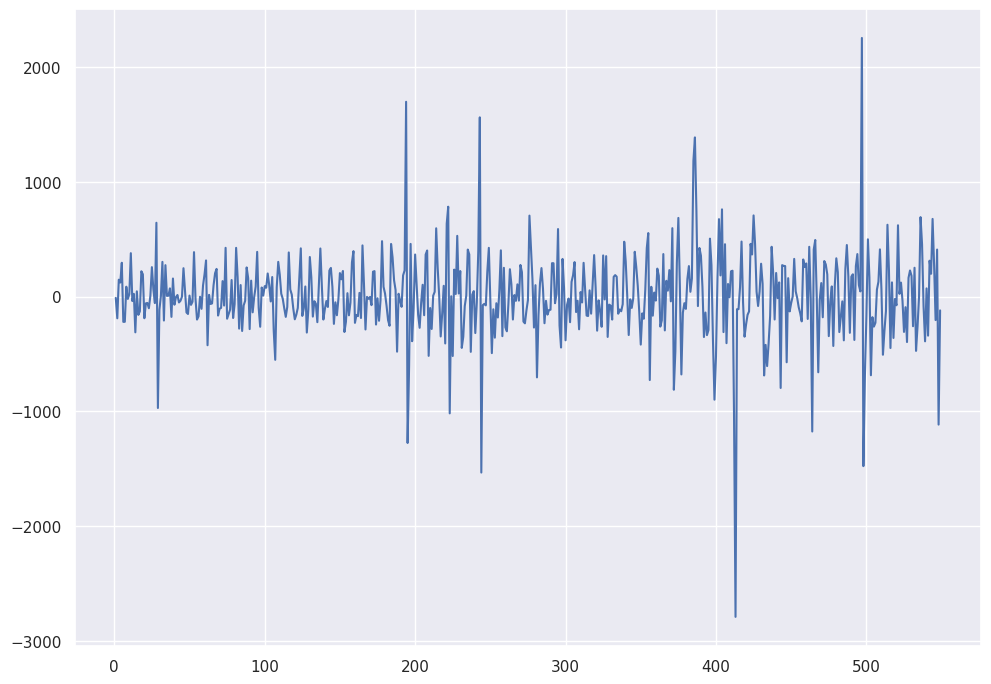

In [ ]:
ts_diff = ts - ts.shift(1)
plt.plot(ts_diff.values)
plt.show()

In [ ]:
ts_diff.dropna(inplace=True)
df_test(ts_diff)

ADF Stastistic: -8.273590
p-value: 0.000000


Now it is stationary

**Choosing p,d,q for ARIMA model**

a thumb rule that for choosing the p,q values are when the lag goes below the significant level
- we use PACF for p, here we see that till lag 5 there are significat lines, if we want our model to be simpler we can start with a smaller number like 3/4
- we use ACF for q. here we can see that lag 4 is below significant level so we will use till lag 3


as for d we can see that at 1 diffencing the series becomes stationary so we choose d as 1

# ACF and PACF

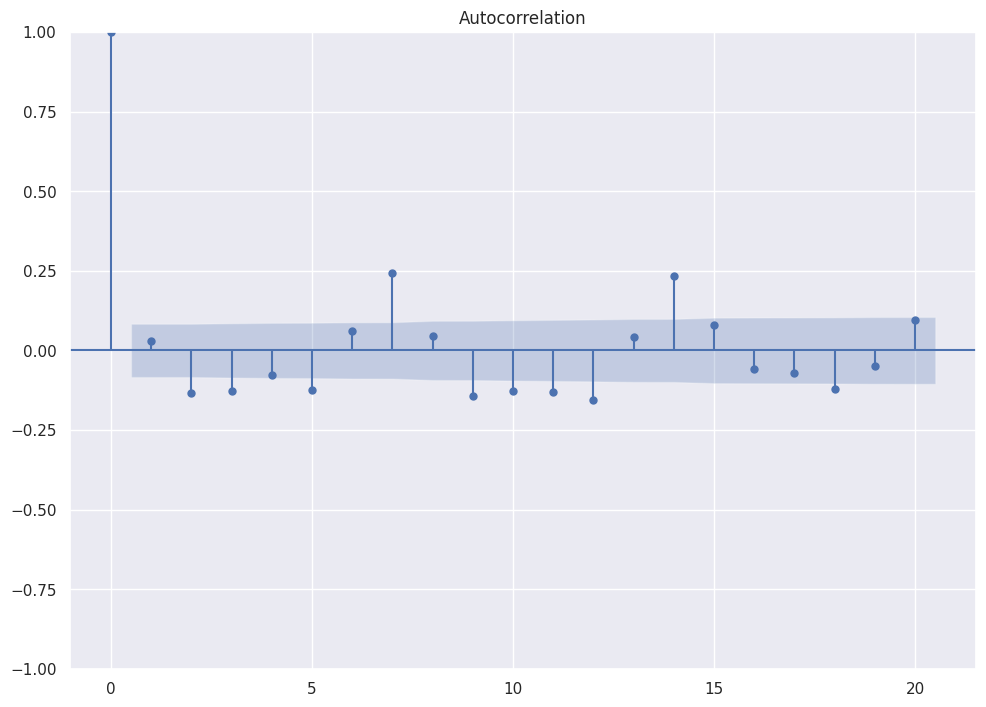

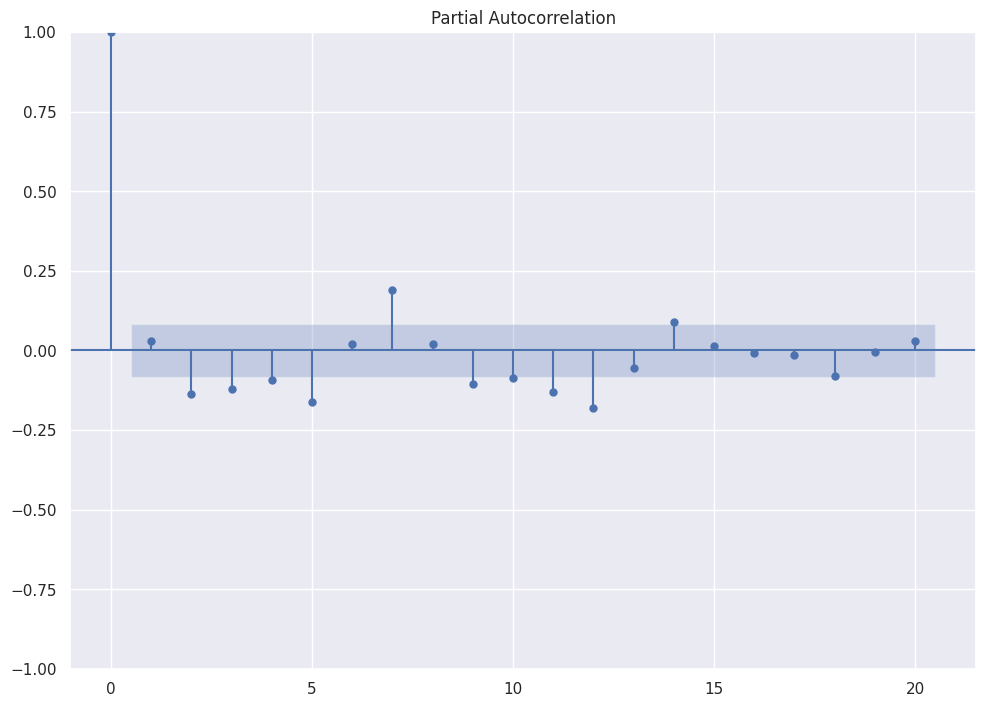

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf=plot_acf(ts_diff,lags=20)
pacf=plot_pacf(ts_diff,lags=20)

# ARIMA  ans SARIMAX MODEL

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame


In [ ]:
train = ts[:-20]
test = ts[-20:]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


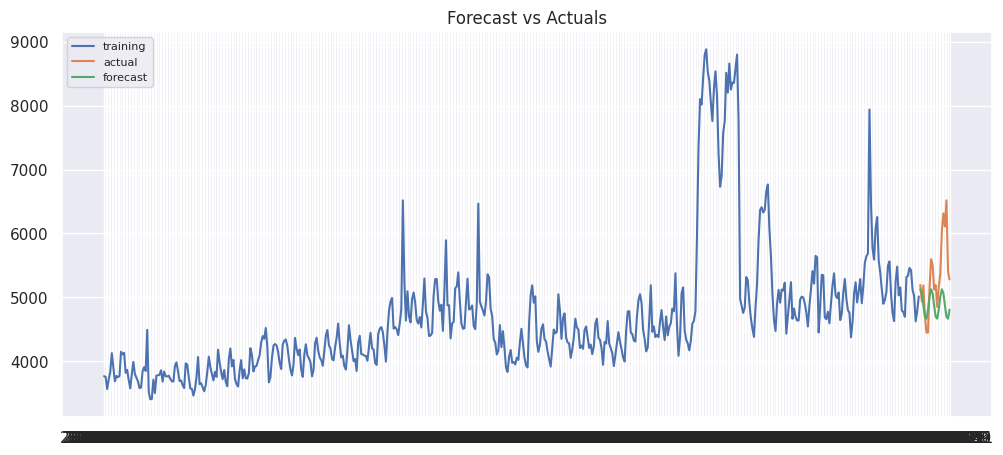

In [ ]:
model = ARIMA(train, order=(4, 1, 3))
fitted = model.fit()

# Forecast
fc_series = fitted.forecast(20, alpha=0.02)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series.index.astype(str), fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

In [ ]:
mape = np.mean(np.abs(fc_series - test.values)/np.abs(test.values))
rmse = np.mean((fc_series - test.values)**2)**.5
print("mape:",mape)
print("rsme:",rmse)

mape: 0.08968868098614681
rsme: 682.637296334911


Model does not perform very well for multistep out sample data

from the decomposition we can see that there is a weekly seasonality and still some spikes in the residual, that may be because of some external factors, which we can take into account by using them as our exogenous variable

In [ ]:
!gdown 1H9054-eVP9IdANPOblXwX7Nd2r_Sjf1u

Downloading...
From: https://drive.google.com/uc?id=1H9054-eVP9IdANPOblXwX7Nd2r_Sjf1u
To: /content/Exog_Campaign_eng
100% 1.10k/1.10k [00:00<00:00, 3.72MB/s]


In [ ]:
ex_df = pd.read_csv('Exog_Campaign_eng')
ex_df.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [ ]:
ex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exog    550 non-null    int64
dtypes: int64(1)
memory usage: 4.4 KB


In [ ]:
ex_df.tail()

,Exog
545,1
546,1
547,1
548,0
549,0


In [ ]:
ex_df.describe()

,Exog
count,550.000000
mean,0.098182
std,0.297831
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
exog=ex_df['Exog'].to_numpy()

In [ ]:
exog

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

we will train a sarimax model for that and see if we get anyimprovements from using the two information.

the seasonal order and the values of PDQ are based upon various trials and comparision of the models

we see a seasonality of 7 from the plots ie: weekly seasonality ( from the plots we can see that afte some insignificant plots we have some significant values repeating at intervals of 7 ie: 7,14 ... )
the non seasonal order we can keep the same

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


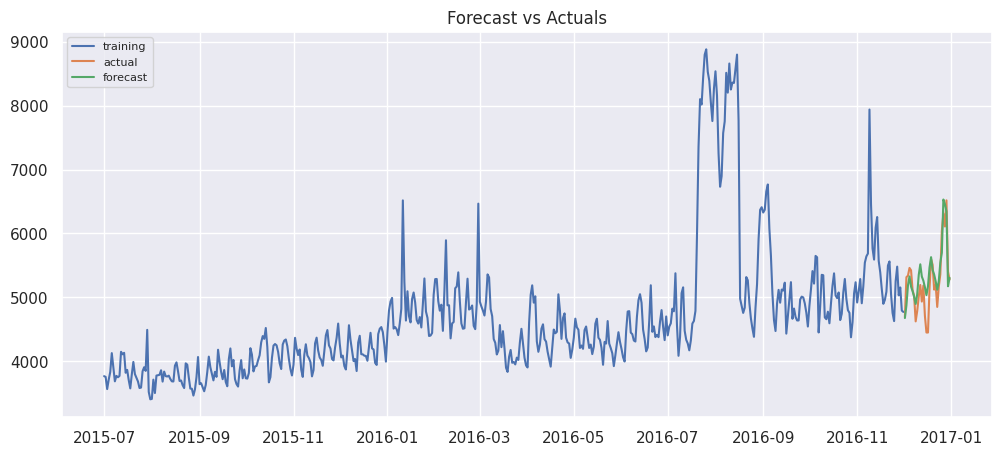

In [ ]:
import statsmodels.api as sm
train=ts[:520]
test=ts[520:]
model=sm.tsa.statespace.SARIMAX(train,order=(4, 1, 3),seasonal_order=(1,1,1,7),exog=exog[:520])
results=model.fit()

fc=results.forecast(30,dynamic=True,exog=pd.DataFrame(exog[520:]))

# Make as pandas series
fc_series = pd.Series(fc)
# Plot
train.index=train.index.astype('datetime64[ns]')
test.index=test.index.astype('datetime64[ns]')
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

In [ ]:
mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
rmse = np.mean((fc - test.values)**2)**.5
print("mape:",mape)
print("rsme:",rmse)

mape: 0.0462866734689745
rsme: 291.1051339895362


MAPE < 5% so this model is good now!

# Regression for a time series

In [ ]:
ts_df=ts.to_frame()
ts_df.head()

,en
index,
2015-07-01,3767.328604
2015-07-02,3755.158765
2015-07-03,3565.225696
2015-07-04,3711.782932
2015-07-05,3833.433025


In [ ]:
ts_df.reset_index(level=0, inplace=True)
ts_df['date']=pd.to_datetime(ts_df['index'])
ts_df.drop(['index'],axis=1,inplace=True)
ts_df.head()

,en,date
0,3767.328604,2015-07-01
1,3755.158765,2015-07-02
2,3565.225696,2015-07-03
3,3711.782932,2015-07-04
4,3833.433025,2015-07-05


In [ ]:
ts_df['day_of_week']=ts_df['date'].dt.day_name()
ts_df.head()


,en,date,day_of_week
0,3767.328604,2015-07-01,Wednesday
1,3755.158765,2015-07-02,Thursday
2,3565.225696,2015-07-03,Friday
3,3711.782932,2015-07-04,Saturday
4,3833.433025,2015-07-05,Sunday


In [ ]:
ts_df=pd.get_dummies(ts_df, columns = ['day_of_week'])

In [ ]:
ts_df.head()

,en,date,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,3767.328604,2015-07-01,False,False,False,False,False,False,True
1,3755.158765,2015-07-02,False,False,False,False,True,False,False
2,3565.225696,2015-07-03,True,False,False,False,False,False,False
3,3711.782932,2015-07-04,False,False,True,False,False,False,False
4,3833.433025,2015-07-05,False,False,False,True,False,False,False


In [ ]:
ts_df['exog']=ex_df['Exog']
ts_df['rolling_mean']=ts_df['en'].rolling(7).mean()

In [ ]:
ts_df=ts_df.dropna()
ts_df.head()

,en,date,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,exog,rolling_mean
6,3906.341724,2015-07-07,False,False,False,False,False,True,False,0,3809.528545
7,3685.854621,2015-07-08,False,False,False,False,False,False,True,0,3797.889404
8,3771.183714,2015-07-09,False,False,False,False,True,False,False,0,3800.178683
9,3749.860313,2015-07-10,True,False,False,False,False,False,False,0,3826.555056
10,3770.749355,2015-07-11,False,False,True,False,False,False,False,0,3834.978831


In [ ]:
X=ts_df[['day_of_week_Friday',	'day_of_week_Monday',	'day_of_week_Saturday',	'day_of_week_Sunday',	'day_of_week_Thursday',	'day_of_week_Tuesday',	'day_of_week_Wednesday',	'exog',	'rolling_mean']].copy()
y=ts_df[['en']]

train_x = X[:-20]
test_x = X[-20:]

train_y = y[:-20]
test_y = y[-20:]


In [ ]:
from sklearn.linear_model import LinearRegression

# Train and pred
model = LinearRegression()
model.fit(train_x, train_y)
y_pred = (model.predict(test_x))


mape = np.mean(np.abs(y_pred - test_y.values)/np.abs(test_y.values))
print("mape:",mape)


mape: 0.045239687363299905


We can see here that aur mape is better than our arima model but worse than our sarimax model

- Linear Regression Is Limited to Linear Relationships and in our case there is not a lot of linear relationship.
- it would have been better to use a regression based model for forecasting if we can build some better features.
- we have our series data and the exogenous variables, we add the day of week feature, other than that there are not a lot of features that we can build

# Facebook Prophet

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to build pystan
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl


In [ ]:
ts_df['ds']=ts_df['date']
ts_df['y']=ts_df['en']

In [ ]:
df2=ts_df[['date','en','exog']].copy()
df2.columns = ['ds', 'y', 'exog']
df2.head()

,ds,y,exog
6,2015-07-07,3906.341724,0
7,2015-07-08,3685.854621,0
8,2015-07-09,3771.183714,0
9,2015-07-10,3749.860313,0
10,2015-07-11,3770.749355,0


In [ ]:
df2[:-20].info()

<class 'pandas.core.frame.DataFrame'>
Index: 524 entries, 6 to 529
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      524 non-null    datetime64[ns]
 1   y       524 non-null    float64       
 2   exog    524 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 16.4 KB


prophet without exogenous

In [ ]:
from fbprophet import Prophet
m = Prophet(weekly_seasonality=True)
m.fit(df2[['ds', 'y']][:-20])
future = m.make_future_dataframe(periods=20,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

ModuleNotFoundError: No module named 'fbprophet'

prophet with exogenous

In [ ]:
model2=Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=1)
model2.add_regressor('exog')
model2.fit(df2[:-20])
forecast2 = model2.predict(df2)
fig = model2.plot(forecast2)

NameError: name 'Prophet' is not defined

In [ ]:
y_true = df2['y'].values
y_pred = forecast2['yhat'].values

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

NameError: name 'forecast2' is not defined

In [ ]:

mape = np.mean(np.abs(forecast2['yhat'][-20:] - df2['y'][-20:].values)/np.abs(df2['y'][-20:].values))
print("mape:",mape)

NameError: name 'forecast2' is not defined

Prophet does not perform well on non-stationary data because it is difficult to find the actual seasonality and trend of the data if the patterns are inconsistent.

# Comparing the predicted views for different languages

For doing this we are going to automate the procedure from loading the separate data for each langauge to doing out of sample forecasting for the next month, and then comparing the results.

In [ ]:
def grid_search(ts):
    v=[0,1,2,3]
    mape=100
    val=[0,0,0]
    for p in v:
        for d in v:
            for q in v:
                try:
                    model = ARIMA(ts[:-20], order=(p,d,q))
                    model_fit = model.fit()
                    fc = model_fit.forecast(20, alpha=0.02)
                    x = np.mean(np.abs(fc - ts[-20:].values)/np.abs(ts[-20:].values))
                    if(x<mape):
                        mape=x
                        val=[p,d,q]

                except:
                    pass

    return(mape, val)

This functions works like a grid search for getting the best value of p,d,q by comparing the mape of all models that we create.

the values of p,d,q that give the least mape score are saved and returned

In [ ]:
def all_arima(train,test,val):
    model = ARIMA(train, order=(val[0], val[1], val[2]))
    fitted = model.fit()

  # Forecast
    fc_series = fitted.forecast(30, alpha=0.02)
    fc_index = pd.date_range(start=test.index[-1], periods=len(fc_series) +1 , freq='D')[1:] #add 1 to periods to avoid starting value collision


  # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
    rmse = np.mean((fc - test.values)**2)**.5
    print("mape:",mape)
    print("rsme:",rmse)
    return (fc)

This function takes the p,d,q values that we calculated earlier and then trains a model on it, does forecast and plots them for visualization.

it also calculates the sum of forecased views for the next 30 days and returns it back

language:  de
0.09353360095431812 [3, 2, 3]


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x79ae02d918d0>.

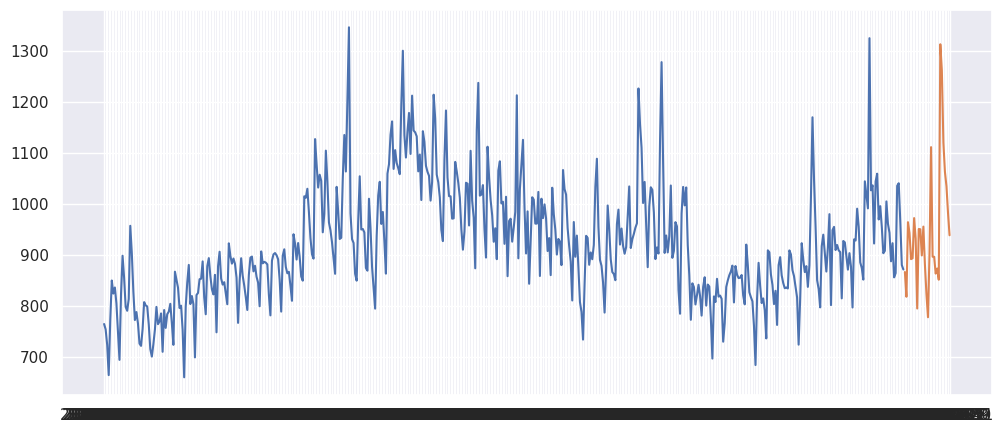

In [ ]:
import warnings
warnings.filterwarnings("ignore")
views_prediction={}
for c in total_view:
    print("language: ",c)
    ts=(total_view[c])
    mape,val=grid_search(ts)
    print(mape,val)
    train = ts[:520]
    test = ts[520:]
    fc=all_arima(train,test,val)
    views_prediction[c]=fc


This function is what calls and drives all the other functions.

It first gets the data for a particular language.

checks stationarity.

Gets the optimal p,d,q values from grid search

uses that value to train the model, forecast and plot it